In [ ]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 
from pyro_oed_src import vnmc_eig

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [21]:
N = 2000 # total number of points
p = 8 # num of samples per each axis of (t_1, t_2)

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
times = np.linspace(0,2*np.pi,N)

designs = torch.tensor(times[indices])
#designs = torch.tensor(indices)
print(designs.shape[-2:])

torch.Size([64, 2])


In [22]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    w = pyro.sample("w", dist.Uniform(w_1,w_2))
    phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2))
    with pyro.plate_stack("plate", t.shape[:-1]): # create a continguous stack of plates, Pyro adds dimensions to the left
        y_true = torch.sin(w*t+phase)
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1)) # to_event: num of batch dimensions (from right) to reinterpret as event dimensions

In [23]:
class posterior_guide_nn(nn.Module):
    def __init__(self, in_features, lay1_out, lay2_out):
        super().__init__()
        self.fa1 = nn.Linear(in_features, lay1_out)
        self.fa2 = nn.Linear(lay1_out, lay2_out)
        self.fa3 = nn.Linear(lay2_out,1)

        self.pa1 = nn.Linear(in_features, lay1_out)
        self.pa2 = nn.Linear(lay1_out, lay2_out)
        self.pa3 = nn.Linear(lay2_out,1)

        self.fb1 = nn.Linear(in_features, lay1_out)
        self.fb2 = nn.Linear(lay1_out, lay2_out)
        self.fb3 = nn.Linear(lay2_out,1)
        
        self.pb1 = nn.Linear(in_features, lay1_out)
        self.pb2 = nn.Linear(lay1_out, lay2_out)
        self.pb3 = nn.Linear(lay2_out,1)


    def freq_nn_a(self, input):
        z = nn.functional.relu(self.fa1(input))
        z = nn.functional.relu(self.fa2(z))
        return self.fa3(z)
    
    def phase_nn_a(self, input):
        z = nn.functional.relu(self.pa1(input))
        z = nn.functional.relu(self.pa2(z))
        return self.pa3(z)
    
    def freq_nn_b(self, input):
        z = nn.functional.relu(self.fb1(input))
        z = nn.functional.relu(self.fb2(z))
        return self.fb3(z)
    
    def phase_nn_b(self, input):
        z = nn.functional.relu(self.pb1(input))
        z = nn.functional.relu(self.pb2(z))
        return self.pb3(z)
    
    def forward(self, y_dict, design, observation_labels, target_labels):

        pyro.module("posterior_guide", self) # registers all parameters of a torch.nn.Module with Pyro's param_store

        y = y_dict["y"].float()
        #z = torch.cat((y,design), dim=-1).float() # concatenate times of design into nn input
        
        freq_alpha = self.freq_nn_a(y).exp()
        phase_alpha = self.phase_nn_a(y).exp()

        freq_beta = self.freq_nn_b(y).exp()
        phase_beta = self.phase_nn_b(y).exp()

        pyro.sample("w", dist.AffineBeta(freq_alpha, freq_beta, 1, 2)) # scaled beta distribution inputs:(alpha, beta, loc, scale) f(X) = loc + scale*X
        pyro.sample("phase", dist.AffineBeta(phase_alpha, phase_beta, np.pi/2, np.pi))

In [24]:
vnmc_upper_bound = []
vnmc_lower_bound = []
pyro.set_rng_seed(4)
num_steps = 100
N = 50
M = np.sqrt(N).astype(int)

nn_guide = posterior_guide_nn(designs.shape[-1], 32, 64)
for times in designs:
    pyro.clear_param_store()
    lower_eig, upper_eig = vnmc_eig(model,
                    times,                          # tensor of possible designs
                    "y",                            # observation labels
                    ["w", "phase"],                 # target (parameter) labels
                    num_samples=(N,M),              # tuple of outer and inner (respectively) num of samples
                    num_steps=num_steps,            # number of gradient steps
                    guide=nn_guide,                 # guide q(y)
                    optim=Adam({'lr': 0.01}),       # optimizer 
                    return_history=False,             # returns a tensor giving the loss function at each step of optimization
                    contrastive=True
                    ) 
    vnmc_lower_bound.append(lower_eig)
    vnmc_upper_bound.append(upper_eig)
    #full_history_vnmc.append((history_lower, history_upper))


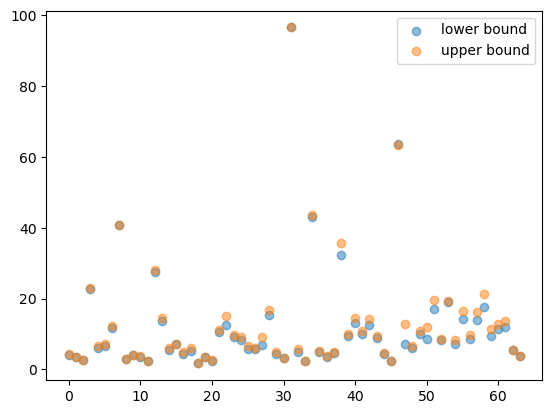

In [25]:
vnmc_lower = np.array([i.detach().numpy() for i in vnmc_lower_bound])
vnmc_upper = np.array([i.detach().numpy() for i in vnmc_upper_bound])
plt.scatter(range(len(designs)), vnmc_lower, alpha=0.5, label="lower bound")
plt.scatter(range(len(designs)), vnmc_upper, alpha=0.5, label="upper bound")
plt.legend()
plt.show()